In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
import training

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.01

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)



In [4]:
## Training parameters 
MAX_EPISODES = 600 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

for seed in [0,1,2,3,4]:
    for complexity in ['plain', 'complex']:
        for phosphene_resolution in [None, 50,42,34,26,18,10]:

            
        
            # Condition-specific configuration
            cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            cfg['seed'] = seed
            torch.manual_seed(seed)
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity,phosphene_resolution,seed)
            print(model_name)
            cfg['logfile'] = 'Out/Exp1/{}_train_stats.csv'.format(model_name)
            cfg['model_path'] = 'Out/Exp1/{}_best_model.pth'.format(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=MEMORY_CAPACITY,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

            optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

            # Start training
            training.train(agent, environment, img_processing, optimizer, cfg)
            print('finished training')

exp1_plain_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -255
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endless_loops: 0, total_reward: 3300
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated

KeyboardInterrupt: 

In [5]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


## Validation:

#### Fast evaluation of trained model

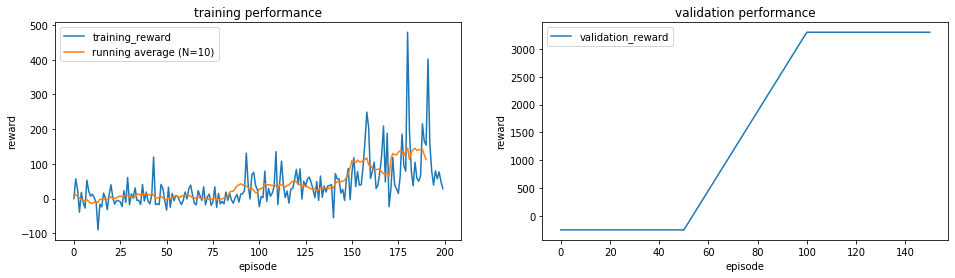

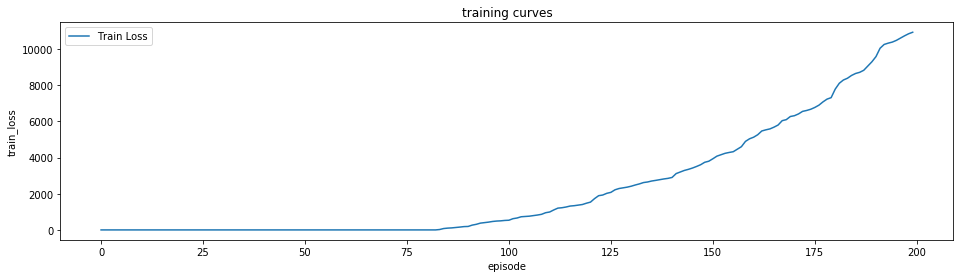

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = 'exp1_plain_phos50_S0'

stats = pd.read_csv('./Out/Exp1/{}_train_stats.csv'.format(MODEL_NAME))

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='train_loss')
plt.title('training curves')
plt.legend(['Train Loss'])

### Further testing and evaluation:

In [1]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing import test

#### Run models on test environment:

In [2]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)
    
img_processing = ImageProcessor

In [3]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp1/{}_best_model.pth'.format(model_name)
            print(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp1/_test_results.csv', index=False)

exp1_plain_phosNone_S0
exp1_plain_phosNone_S1
exp1_plain_phosNone_S2
exp1_plain_phosNone_S3
exp1_plain_phosNone_S4
exp1_plain_phos50_S0
exp1_plain_phos50_S1
exp1_plain_phos50_S2
exp1_plain_phos50_S3
exp1_plain_phos50_S4
exp1_plain_phos42_S0
exp1_plain_phos42_S1
exp1_plain_phos42_S2
exp1_plain_phos42_S3
exp1_plain_phos42_S4
exp1_plain_phos34_S0
exp1_plain_phos34_S1
exp1_plain_phos34_S2
exp1_plain_phos34_S3
exp1_plain_phos34_S4
exp1_plain_phos26_S0
exp1_plain_phos26_S1
exp1_plain_phos26_S2
exp1_plain_phos26_S3
exp1_plain_phos26_S4
exp1_plain_phos18_S0
exp1_plain_phos18_S1
exp1_plain_phos18_S2
exp1_plain_phos18_S3
exp1_plain_phos18_S4
exp1_plain_phos10_S0
exp1_plain_phos10_S1
exp1_plain_phos10_S2
exp1_plain_phos10_S3
exp1_plain_phos10_S4
exp1_complex_phosNone_S0
exp1_complex_phosNone_S1
exp1_complex_phosNone_S2
exp1_complex_phosNone_S3
exp1_complex_phosNone_S4
exp1_complex_phos50_S0
exp1_complex_phos50_S1
exp1_complex_phos50_S2
exp1_complex_phos50_S3
exp1_complex_phos50_S4
exp1_complex_ph

In [5]:
test_data = pd.read_csv('./Out/Exp1/_test_results.csv') 
test_data

,complexity,phosphene_resolution,seed,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
0,plain,NaN,0,5,5,0,118,743
1,plain,NaN,1,0,2,0,111,885
2,plain,NaN,2,0,4,2,116,820
3,plain,NaN,3,0,2,0,113,883
4,plain,NaN,4,1,5,4,125,772
...,...,...,...,...,...,...,...,...
65,complex,10.0,0,0,8,0,101,715
66,complex,10.0,1,0,13,0,103,585
67,complex,10.0,2,0,11,0,96,630
68,complex,10.0,3,5,8,2,118,653


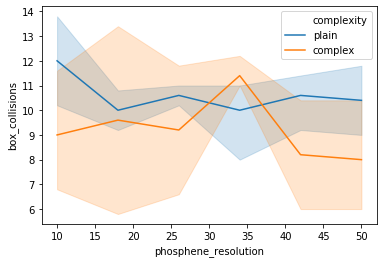

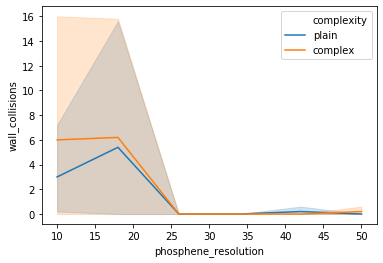

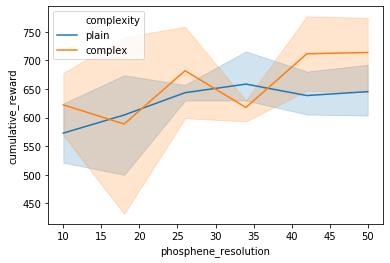

In [7]:
sns.lineplot(data=test_data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

#### Training and validation curves

In [74]:
all_stats = pd.DataFrame()
best_stats = pd.DataFrame()
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            train_csv = './Out/Exp1/{}_train_stats.csv'.format(model_name)
            train_stats = pd.read_csv(train_csv)
            train_stats['complexity'] = complexity
            train_stats['resolution'] = phosphene_resolution
            train_stats['seed'] = seed
            train_stats['model_name'] = model_name
            
            # append all rows
            all_stats = all_stats.append(train_stats,ignore_index=True)
            
            # append only best-performing validation row
            val = train_stats.loc[train_stats.validation==1].reset_index()
            best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)


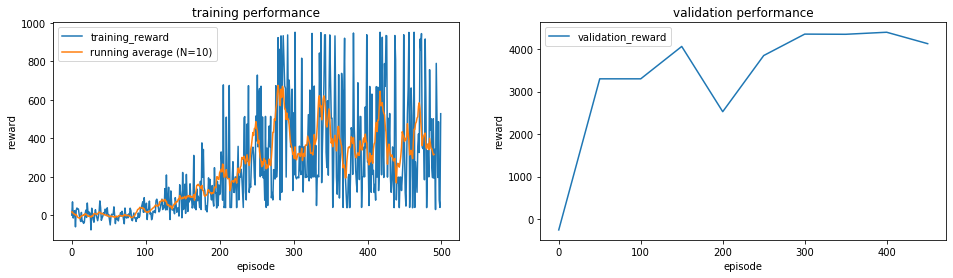

In [75]:
MODEL_NAME = 'exp1_plain_phos18_S2'

stats = all_stats.loc[all_stats.model_name==MODEL_NAME]

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()


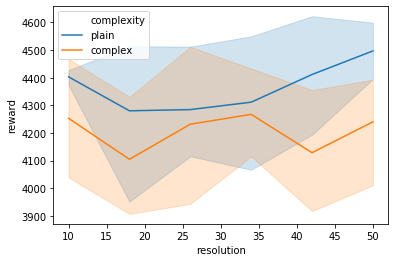

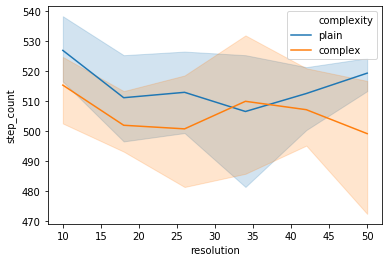

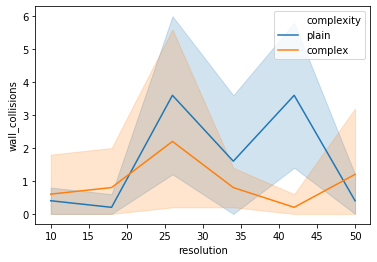

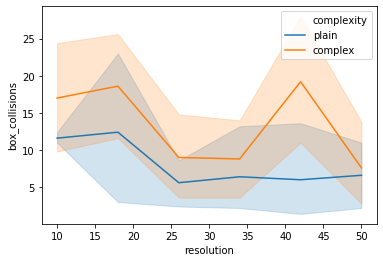

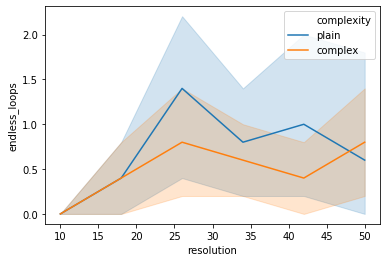

In [67]:
for y in ['reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    sns.lineplot(data=best_stats, x='resolution',y=y,hue='complexity')
    plt.show()